In [1]:
## general
import numpy as np
import datetime
from sklearn.externals import joblib
import copy
import cf_units
import xarray as xr
import os
import sys
from tqdm import tqdm_notebook as tqdm


## statistics
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy import stats
from scipy.stats import multivariate_normal # to compute likelihood
from scipy.optimize import curve_fit

# statistics which aren't all that nice in python
import rpy2.robjects as robjects

## my stuff
sys.path.insert(1,'/home/snath/polybox/LAMACLIMA/')
from tools.loading import load_data_single_mod
from tools.processing import AR1_predict, compute_llh_cv,gaspari_cohn
from tools.plotting import TaylorDiagram


## plotting
import matplotlib.pyplot as plt
import numpy.ma as ma
import cartopy.crs as ccrs

##for parallelisation
from sklearn.externals.joblib import Parallel, delayed

/home/snath/anaconda3/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Error: package or namespace load failed for ‘RevoUtilsMath’:
 .onLoad failed in loadNamespace() for 'RevoUtilsMath', details:
  call: NULL
  error: Remove Microsoft R and then re-install.
Be sure to select MKL libraries as an install option.

  warnings.warn(x, RRuntimeWarning)
In /home/snath/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/snath/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/snath/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [4]:
models = ['ACCESS-CM2','ACCESS-ESM1-5','AWI-CM-1-1-MR','BCC-CSM2-MR','CAMS-CSM1-0','CESM2-WACCM','CESM2','CIESM','CMCC-CM2-SR5','CNRM-CM6-1-HR','CNRM-CM6-1','CNRM-ESM2-1',
          'CanESM5','EC-Earth3-Veg','EC-Earth3','FGOALS-f3-L','FGOALS-g3','FIO-ESM-2-0','GFDL-CM4','GFDL-ESM4','HadGEM3-GC31-LL','HadGEM3-GC31-MM',
         'INM-CM4-8','INM-CM5-0','IPSL-CM6A-LR','KACE-1-0-G','KIOST-ESM','MCM-UA-1-0','MIROC-ES2L','MIROC6','MPI-ESM1-2-HR',
         'MPI-ESM1-2-LR','MRI-ESM2-0','NESM3','NorESM2-LM','NorESM2-MM','TaiESM1','UKESM1-0-LL']#CanESM5-CanOE,'IPSL-CM6A-LR'



run_nrs={}
run_nrs['ACCESS-CM2']=[1,2]
run_nrs['ACCESS-ESM1-5']=[1,2,3,4,5,6,7]
run_nrs['AWI-CM-1-1-MR']=[1]
run_nrs['BCC-CSM2-MR']=[1]
run_nrs['CAMS-CSM1-0']=[1]
run_nrs['CESM2-WACCM']=[1,2]
run_nrs['CESM2']=[1,2,4]
run_nrs['CIESM']=[1]
run_nrs['CMCC-CM2-SR5']=[1]
run_nrs['CNRM-CM6-1-HR']=[1]
run_nrs['CNRM-CM6-1']=[1,2,3,4]
run_nrs['CNRM-ESM2-1']=[1,2,3]
run_nrs['CanESM5-CanOE']=[1,2]
run_nrs['CanESM5']=[1,2,3,4,5,6,7,8,9,10,11,12,13]
run_nrs['EC-Earth3-Veg']=[1,2,3]
run_nrs['EC-Earth3']=[1,4,6,9]
run_nrs['FGOALS-f3-L']=[1]
run_nrs['FGOALS-g3']=[1,2]
run_nrs['FIO-ESM-2-0']=[1,2]
run_nrs['GFDL-CM4']=[1]
run_nrs['GFDL-ESM4']=[1]
run_nrs['HadGEM3-GC31-LL']=[1,2]
run_nrs['HadGEM3-GC31-MM']=[1,2]
run_nrs['INM-CM4-8']=[1]
run_nrs['INM-CM5-0']=[1]
run_nrs['IPSL-CM6A-LR']=[1,2,3,4]
run_nrs['KACE-1-0-G']=[1,2]
run_nrs['KIOST-ESM']=[1]
run_nrs['MCM-UA-1-0']=[1]
run_nrs['MIROC-ES2L']=[1]
run_nrs['MIROC6']=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,
                   17,18,19,20,21,22,23,24,25]
run_nrs['MPI-ESM1-2-HR']=[1]
run_nrs['MPI-ESM1-2-LR']=[1,2,3,4,5,6,7]
run_nrs['MRI-ESM2-0']=[1]
run_nrs['NESM3']=[1]
run_nrs['NorESM2-LM']=[1]
run_nrs['NorESM2-MM']=[1]
run_nrs['TaiESM1']=[1]
run_nrs['UKESM1-0-LL']=[1,2,3]

test_run_nrs={}
test_run_nrs['ACCESS-CM2']=[3]
test_run_nrs['ACCESS-ESM1-5']=[8,9,10]
test_run_nrs['AWI-CM-1-1-MR']=[1]
test_run_nrs['BCC-CSM2-MR']=[1]
test_run_nrs['CAMS-CSM1-0']=[2]
test_run_nrs['CESM2-WACCM']=[3]
test_run_nrs['CESM2']=[10,11]
test_run_nrs['CIESM']=[1]
test_run_nrs['CMCC-CM2-SR5']=[1]
test_run_nrs['CNRM-CM6-1-HR']=[1]
test_run_nrs['CNRM-CM6-1']=[5,6]
test_run_nrs['CNRM-ESM2-1']=[4,5]
test_run_nrs['CanESM5-CanOE']=[3]
test_run_nrs['CanESM5']=[14,15,16,17,18,19,20,21,22,23,24,25]
test_run_nrs['EC-Earth3-Veg']=[4,6]
test_run_nrs['EC-Earth3']=[11,13,15]
test_run_nrs['FGOALS-f3-L']=[1]
test_run_nrs['FGOALS-g3']=[3,4]
test_run_nrs['FIO-ESM-2-0']=[3]
test_run_nrs['GFDL-CM4']=[1]
test_run_nrs['GFDL-ESM4']=[1]
test_run_nrs['HadGEM3-GC31-LL']=[3,4]
test_run_nrs['HadGEM3-GC31-MM']=[3]
test_run_nrs['INM-CM4-8']=[1]
test_run_nrs['INM-CM5-0']=[1]
test_run_nrs['IPSL-CM6A-LR']=[6,14]
test_run_nrs['KACE-1-0-G']=[3]
test_run_nrs['KIOST-ESM']=[1]
test_run_nrs['MCM-UA-1-0']=[1]
test_run_nrs['MIROC-ES2L']=[1]
test_run_nrs['MIROC6']=[26,27,28,29,30,
                   31,32,33,34,35,36,37,38,39,40,
                        41,42,43,44,45,46,47,48,49,50]
test_run_nrs['MPI-ESM1-2-HR']=[2]
test_run_nrs['MPI-ESM1-2-LR']=[8,9,10]
test_run_nrs['MRI-ESM2-0']=[1]
test_run_nrs['NESM3']=[2]
test_run_nrs['NorESM2-LM']=[1]
test_run_nrs['NorESM2-MM']=[1]
test_run_nrs['TaiESM1']=[1]
test_run_nrs['UKESM1-0-LL']=[4,8]


In [13]:
Tanglob_wgt={}
y={}
time={}
y_mon={}
time_mon={}

y_all_mon={}
y_all={}

train_results_all={}
test_results_all={}

y_all_mon_test={}
y_all_test={}


train_residue_all={}
test_residue_all={}

pearson_alb_mon={}
feature_im={}
pearson_alb={}

dir_data = '/net/so4/landclim/snath/data/cmip6-ng/train_test_split_final/'

for model in models:
    dir_in_data_mod = dir_data+'tas_mon'+'_'+model+'_rcp85_g025/'
    print("Getting seasonal trends for" ,model)

    train_results_all[model]=joblib.load(dir_in_data_mod+'seasonal_training_results.pkl')
    test_results_all[model]=joblib.load(dir_in_data_mod+'seasonal_test_results.pkl')
    
    ##Get training values i.e. monthly/daily model run datas for selected models
    y_mon[model],time_mon[model],srex,srex_names,lon_pc,lat_pc,idx_l,wgt_l=load_data_single_mod(6,model,'ssp585',Tanglob_idx=False,Tref_all=True,Tref_start='1870-01-01',Tref_end='1900-01-01',usr_time_res="mon")

    # T fields
    y[model],time[model],srex,srex_names,lon_pc,lat_pc,idx_l,wgt_l,Tanglob_wgt[model]=load_data_single_mod(6,model,'ssp585',Tanglob_idx=True,Tref_all=True,Tref_start='1870-01-01',Tref_end='1900-01-01')

    #Get model
    nr_ts = len(time[model]) #nr time steps (CAMS-CSM1-0 is 230, all others 231)

    ##get training data

    # prepare the inputs as array
    y_all[model] = np.zeros([nr_ts*len(run_nrs[model]),idx_l.sum()]) 
    y_all_mon[model] = np.zeros([12*nr_ts*len(run_nrs[model]),idx_l.sum()]) 

    i_mon=0
    i=0
    for run in run_nrs[model]:
        y_all[model][i:i+nr_ts]=y[model][run][:nr_ts,:]
        y_all_mon[model][i_mon:i_mon+(nr_ts*12)]=y_mon[model][run][:12*nr_ts,:]
        i_mon+=(nr_ts*12)
        i+=nr_ts

    y_all_mon_test[model] = np.zeros([12*nr_ts*len(test_run_nrs[model]),idx_l.sum()]) 
    y_all_test[model] = np.zeros([nr_ts*len(test_run_nrs[model]),idx_l.sum()]) 

    i=0
    i_mon=0
    for run in test_run_nrs[model]:
        y_all_test[model][i:i+nr_ts]=y[model][run][:nr_ts,:]
        y_all_mon_test[model][i_mon:i_mon+(12*nr_ts)]=y_mon[model][run][:12*nr_ts,:]
        i+=nr_ts
        i_mon+=12*nr_ts
        
    ##get gbr predicted residuals    
    dir_data_out_mod = dir_data+'tas_mon'+'_'+model+'_rcp85_g025/albedo_tests_ens_gbr/'
    train_residue_all[model]={}
    test_residue_all[model]={}
    
    pearsonr_alb[model]={}
    pearsonr_alb_mon[model]={}
    
    pearsonr_alb[model]['Org']=np.zeros([idx_l.sum()])
    pearsonr_alb_mon[model]['Org']=np.zeros([12,idx_l.sum()])
    
    for i_grid in np.arange(idx_l.sum()):

        for i_mon in range(12):
            pearsonr_alb_mon[model]['Org'][i_mon,i_grid]=pearsonr(y_all_mon_test[model].reshape(-1,12,idx_l.sum())[:,i_mon,i_grid],test_results_all[model].reshape(-1,12,idx_l.sum())[:,i_mon,i_grid])[0]

        pearsonr_alb[model]['Org'][i_grid]=np.average(pearsonr_alb_mon[model]['Org'][:,i_grid],weights=np.std(y_all_mon_test[model].reshape(-1,12,idx_l.sum())[:,:,i_grid],axis=0))


    
    labels=['A','C','S','Hl','Hs','H','AC','AS','CS','HA','HC','HS','ACS','HAC','HCS','HAS','Tyr_mon','HACS']
    #labels=['HACS']
    for i_mod,res_model in enumerate(labels):
         
        dir_data_out_mod = dir_data+'tas_mon'+'_'+model+'_rcp85_g025/albedo_tests_ens_gbr/'
        dir_data_out_mod_gbr=dir_data_out_mod+res_model+'/'
        dir_data_out_mod_gbr_hacs=dir_data_out_mod+'HACS/'
        if not (os.path.exists(dir_data_out_mod_gbr_hacs)):
            continue
        
        print('Loading fitted results')
        train_residue_all[model][res_model]=joblib.load(dir_data_out_mod_gbr+'year_seasonal_albedo_svm_results.pkl')
        test_residue_all[model][res_model]=joblib.load(dir_data_out_mod_gbr+'year_seasonal_albedo_svm_test_results.pkl')

        load_model=joblib.load(dir_data_out_mod_gbr+'year_seasonal_albedo_svm_ingredients.pkl')
        
        pearsonr_alb[model][res_model]=np.zeros([idx_l.sum()])
        pearsonr_alb_mon[model][res_model]=np.zeros([12,idx_l.sum()])
        
        
        if model=='NorESM2-LM' or model=='NorESM2-MM':
            test_all_albfd=test_results_all[model]+np.insert(test_residue_all[model][res_model],1740,0,axis=0)
        else:
            test_all_albfd=test_results_all[model]+test_residue_all[model][res_model]
        
        if res_model=='HACS':
            features=load_model[0].n_features_

            feature_imp[model]=np.zeros([features,idx_l.sum()])
        for i_grid in np.arange(idx_l.sum()):
            
            if res_model=='HACS':
                feature_imp[model][:,i_grid]=load_model[i_grid].feature_importances_[:]

            for i_mon in range(12):
                if model=='EC-EARTH':
                    pearsonr_alb_mon[model][res_model][i_mon,i_grid]=pearsonr(y_all_mon_test[model].reshape(-1,12,idx_l.sum())[:nr_ts,i_mon,i_grid],test_all_albfd.reshape(-1,12,idx_l.sum())[:,i_mon,i_grid])[0]
                else:
                    pearsonr_alb_mon[model][res_model][i_mon,i_grid]=pearsonr(y_all_mon_test[model].reshape(-1,12,idx_l.sum())[:,i_mon,i_grid],test_all_albfd.reshape(-1,12,idx_l.sum())[:,i_mon,i_grid])[0]

            pearsonr_alb[model][res_model][i_grid]=np.average(pearsonr_alb_mon[model][res_model][:,i_grid],weights=np.std(y_all_mon_test[model].reshape(-1,12,idx_l.sum())[:,:,i_grid],axis=0))


Getting seasonal trends for BCC-CSM2-MR
start with model BCC-CSM2-MR


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model BCC-CSM2-MR


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Getting seasonal trends for CESM2-WACCM
start with model CESM2-WACCM


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model CESM2-WACCM


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Getting seasonal trends for CESM2
start with model CESM2


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model CESM2


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Getting seasonal trends for CIESM
start with model CIESM


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model CIESM


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Getting seasonal trends for CMCC-CM2-SR5
start with model CMCC-CM2-SR5


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model CMCC-CM2-SR5


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Getting seasonal trends for CNRM-CM6-1-HR
start with model CNRM-CM6-1-HR


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model CNRM-CM6-1-HR


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Getting seasonal trends for CNRM-CM6-1
start with model CNRM-CM6-1


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model CNRM-CM6-1


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Getting seasonal trends for CNRM-ESM2-1
start with model CNRM-ESM2-1


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model CNRM-ESM2-1


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Getting seasonal trends for CanESM5
start with model CanESM5


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model CanESM5


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Getting seasonal trends for EC-Earth3-Veg
start with model EC-Earth3-Veg


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model EC-Earth3-Veg


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Getting seasonal trends for EC-Earth3
start with model EC-Earth3


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model EC-Earth3


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Getting seasonal trends for FGOALS-f3-L
start with model FGOALS-f3-L


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model FGOALS-f3-L


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Getting seasonal trends for GFDL-CM4
start with model GFDL-CM4


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model GFDL-CM4


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Getting seasonal trends for GFDL-ESM4
start with model GFDL-ESM4


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model GFDL-ESM4


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Getting seasonal trends for HadGEM3-GC31-LL
start with model HadGEM3-GC31-LL


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model HadGEM3-GC31-LL


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Getting seasonal trends for HadGEM3-GC31-MM
start with model HadGEM3-GC31-MM


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model HadGEM3-GC31-MM


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Getting seasonal trends for IPSL-CM6A-LR
start with model IPSL-CM6A-LR


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model IPSL-CM6A-LR


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Getting seasonal trends for MIROC-ES2L
start with model MIROC-ES2L


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model MIROC-ES2L


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Getting seasonal trends for MIROC6
start with model MIROC6


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model MIROC6


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Getting seasonal trends for MPI-ESM1-2-HR
start with model MPI-ESM1-2-HR


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model MPI-ESM1-2-HR


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Getting seasonal trends for MPI-ESM1-2-LR
start with model MPI-ESM1-2-LR


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model MPI-ESM1-2-LR


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Getting seasonal trends for MRI-ESM2-0
start with model MRI-ESM2-0


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model MRI-ESM2-0


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Getting seasonal trends for NorESM2-MM
start with model NorESM2-MM


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model NorESM2-MM


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Getting seasonal trends for UKESM1-0-LL
start with model UKESM1-0-LL


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model UKESM1-0-LL


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results
Loading fitted results


In [ ]:
## Load CMIP6 emulations
emu_res_fmin={}
emu_res_fmin_test={}
train_residue_all={}
test_residue_all={}

full_emu={}
full_emu_test={}

nr_emus=50
for model in models:
    
    nr_ts=len(time[model])
    
    print('Getting loc var monthly emulations for: ', model)
    train_residue_all[model]=y_all_mon[model]-train_results_all[model]
    test_residue_all[model]=y_all_mon_test[model]-test_results_all[model]
    
    dir_in_data_mod = dir_data+'tas_mon'+'_'+model+'_rcp85_g025/'
    
    emu_res_fmin[model]=np.zeros([nr_emus*len(run_nrs[model]),nr_ts
                                ,2,idx_l.sum()])
    emu_res_fmin_test[model]=np.zeros([nr_emus*len(test_run_nrs[model]),nr_ts
                                ,2,idx_l.sum()])
    full_emu[model]=np.zeros_like(emu_res_fmin[model])
    full_emu_test[model]=np.zeros_like(emu_res_fmin_test[model])
    
    i_emu=0
    for run in run_nrs[model][:3]:
        emu_temp=joblib.load(dir_in_data_mod+'r%i_%i_emulator_innovations_fmin_log.pkl'%(run,nr_emus))
                    
        for emu in np.arange(nr_emus):
            emu_res_fmin[model][i_emu,:,0,:]=emu_temp[emu][:,0,:]
            emu_res_fmin[model][i_emu,:,1,:]=emu_temp[emu][:,6,:]
            
            i_emu+=1
    
    i_emu=0
    for run in test_run_nrs[model][:3]:
        emu_temp=joblib.load(dir_in_data_mod+'r%i_%i_emulator_innovations_fmin_log.pkl'%(run,nr_emus))
           
        for emu in np.arange(nr_emus):
            emu_res_fmin_test[model][i_emu,:,0,:]=emu_temp[emu][:,0,:]
            emu_res_fmin_test[model][i_emu,:,1,:]=emu_temp[emu][:,6,:]
            i_emu+=1
            

    
    print('Getting full emulations for: ', model)
    i_emu=0
    i_mon=0
    for run in run_nrs[model]:
        for emu in range(nr_emus):
            full_emu[model][i_emu,:,:,:]=emu_res_fmin[model][i_emu,:,:,:]+train_results_all[model][i_mon:i_mon+(nr_ts*12),:].reshape(-1,12,idx_l.sum())[:,[0,6],:]
            i_emu+=1
        i_mon+=12*nr_ts
        
    
    i_emu=0
    i_mon=0
    for run in test_run_nrs[model]:
        for emu in range(nr_emus):
            full_emu_test[model][i_emu,:,:,:]=emu_res_fmin_test[model][i_emu,:,:,:]+test_results_all[model][i_mon:i_mon+(nr_ts*12),:].reshape(-1,12,idx_l.sum())[:,[0,6],:]
            i_emu+=1
        i_mon+=12*nr_ts

In [ ]:
from scipy.special import kl_div,rel_entr
from scipy.stats import energy_distance

#het_sked={}
#kldiv={}

for model in models:
    
    print('Calculating statistics for: ', model)
    
    dir_data_out_mod_gbr = dir_data+'tas_mon'+'_'+model+'_rcp85_g025/albedo_tests_ens_gbr/HACS/'
    gbr_residue_all=joblib.load(dir_data_out_mod_gbr+'year_seasonal_albedo_svm_results.pkl')
    
    
    kldiv[model]=np.zeros([3,2,idx_l.sum()])
    nr_ts=len(time[model])
    
    if model=='NorESM2-LM' or model=='NorESM2-MM':
        train_all_albfd=train_results_all[model].reshape(-1,12,idx_l.sum())+np.insert(gbr_residue_all,1740,0,axis=0).reshape(-1,12,idx_l.sum())
    else:
        train_albfd_all=train_results_all[model].reshape(-1,12,idx_l.sum())+gbr_residue_all.reshape(-1,12,idx_l.sum())
    
    print('Calculating Cramer von-Mises criterion now')
    for i_mon,mon in enumerate([0,6]):
        kldiv[model][1,i_mon,:]=np.array([energy_distance(y_all_mon[model].reshape(-1,12,idx_l.sum())[:,mon,i_grid],
                                                          train_albfd_all[:,mon,i_grid]
                                    ) for i_grid in np.arange(idx_l.sum())])
        kldiv[model][2,i_mon,:]=np.array([energy_distance(y_all_mon[model].reshape(-1,12,idx_l.sum())[:,mon,i_grid],
                                                          full_emu[model][:,:,:,:].reshape(-1,2,idx_l.sum())[:,i_mon,i_grid]
                                                           ) for i_grid in np.arange(idx_l.sum())])#np.arange(0,50*len(run_nrs[model]),50).tolist()


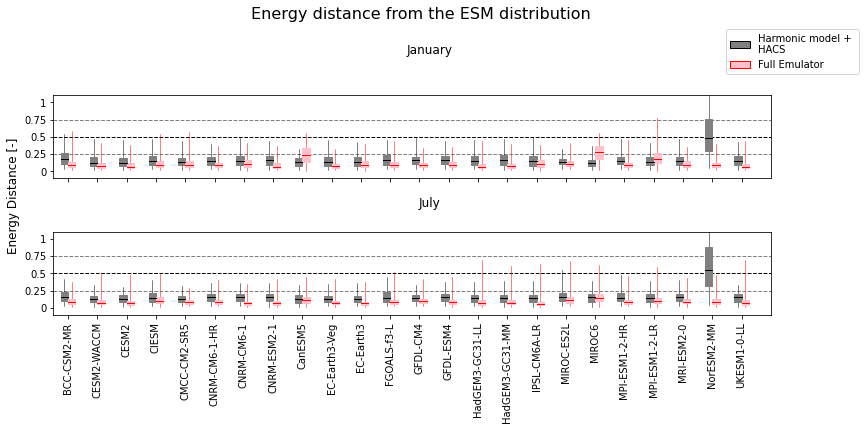

In [9]:
from matplotlib.patches import Patch


fs_title=16
months=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
n_row = 11*4

dir_data = '/net/so4/landclim/snath/data/cmip6-ng/train_test_split_final/'
dir_in_data_mod = '/net/so4/landclim/snath/data/cmip5_cmip6_comb_results/'
labels=joblib.load(dir_in_data_mod+'labels.pkl')
kldiv=joblib.load(dir_data+'kldiv_emergency_dump_all_mod.pkl')

#plt.figure(figsize=(12, n_row * 1.2))
plt.figure(figsize=(15, 10))

plt.rcParams.update({'font.size': 10})
#plt.rcParams.update({'mathtext.default':'regular'}) 
plt.rcParams.update({'mathtext.default':'it'}) 

#grid = plt.GridSpec(n_row*7+6, 81, wspace=0, hspace=0.15) # create a grid for the subplots #0.12
grid = plt.GridSpec(32, 98, wspace=0, hspace=0.15) # create a grid for the subplots #0.12

axtitle = plt.subplot(grid[0,:-12])
plt.title('Energy distance from the ESM distribution',y=-0,fontsize=fs_title)
plt.axis('off')

models=list(kldiv.keys())
i=4

xticks= np.arange(1,len(models)+1)
xticks[1:]=xticks[1:]*2-1

xticks_1=xticks-0.25

xticks_2=xticks+0.25

ax1=plt.subplot(grid[i+1:i+6,:-14])
    
for mod in range(len(models)):
    bp1=plt.boxplot(kldiv[models[mod]][1,0,:][~np.isnan(kldiv[models[mod]][1,0,:])],positions=[xticks_1[mod]],whis=[0,100],showfliers=False,showcaps=False,patch_artist=True,widths=0.5)
    for element in ['boxes', 'whiskers']:
        if element=='whiskers':
            plt.setp(bp1[element], color='black',linewidth=0.5)
        else:
            plt.setp(bp1[element], color='grey')
    plt.setp(bp1['medians'],color='black')

    bp2=plt.boxplot(kldiv[models[mod]][2,0,:][~np.isnan(kldiv[models[mod]][2,0,:])],positions=[xticks_2[mod]],whis=[0,100],showfliers=False,showcaps=False,patch_artist=True,widths=0.5)
    for element in ['boxes', 'whiskers']:
        if element=='whiskers':
            plt.setp(bp2[element], color='red',linewidth=0.5)   
        else:
            plt.setp(bp2[element], color='pink')

    plt.setp(bp2['medians'],color='red')

plt.hlines([0.25,0.75],0,xticks.max()+2,color='gray',linestyle='--',linewidth=1)
plt.hlines([0.5],0,xticks.max()+2,color='k',linestyle='--',linewidth=1)


plt.yticks([0,0.25,0.5,0.75,1],[0,0.25,0.5,0.75,1])
plt.ylabel('Energy Distance [-]',y=-0.2, fontsize=12)
xk=plt.xticks(xticks, [])
ax1.set_ylim([-0.1,1.1])
ax1.set_xlim([0,(len(models))*2+1])


i+=8

ax1=plt.subplot(grid[i+1:i+6,:-14])

xticks= np.arange(1,len(models)+1)
xticks[1:]=xticks[1:]*2-1

xticks_1=xticks-0.25

xticks_2=xticks+0.25
    
for mod in range(len(models)):
    bp1=plt.boxplot(kldiv[models[mod]][1,1,:][~np.isnan(kldiv[models[mod]][1,1,:])],positions=[xticks_1[mod]],whis=[0,100],showfliers=False,showcaps=False,patch_artist=True,widths=0.5)
    for element in ['boxes', 'whiskers']:
        if element=='whiskers':
            plt.setp(bp1[element], color='black',linewidth=0.5)
        else:
            plt.setp(bp1[element], color='grey')
    plt.setp(bp1['medians'],color='black')

    bp2=plt.boxplot(kldiv[models[mod]][2,1,:][~np.isnan(kldiv[models[mod]][2,1,:])],positions=[xticks_2[mod]],whis=[0,100],showfliers=False,showcaps=False,patch_artist=True,widths=0.5)
    for element in ['boxes', 'whiskers']:
        if element=='whiskers':
            plt.setp(bp2[element], color='red',linewidth=0.5)   
        else:
            plt.setp(bp2[element], color='pink')

    plt.setp(bp2['medians'],color='red')


plt.yticks([0,0.25,0.5,0.75,1],[0,0.25,0.5,0.75,1])

xk=plt.xticks(xticks, models,rotation=90)
ax1.set_ylim([-0.1,1.1])
ax1.set_xlim([0,(len(models))*2+1])

plt.hlines([0.25,0.75],0,xticks.max()+2,color='gray',linestyle='--',linewidth=1)
plt.hlines([0.5],0,xticks.max()+2,color='k',linestyle='--',linewidth=1)

xtitle=plt.subplot(grid[2,5:-15])
plt.title('January',y=-0.02)
plt.axis('off')

axtitle=plt.subplot(grid[11,5:-15])
plt.title('July',y=-0.02)
plt.axis('off')



legend_elements = [Patch(facecolor='grey', edgecolor='k',
                         label='Harmonic model + \nHACS'),
                  Patch(facecolor='pink', edgecolor='r',
                         label='Full Emulator')]

axlegend=plt.subplot(grid[1:4,-15:-8])
plt.legend(handles=legend_elements, loc='center')
plt.axis('off')
plt.savefig('/net/so4/landclim/snath/cvm_dist_all_esm.pdf', dpi=300)


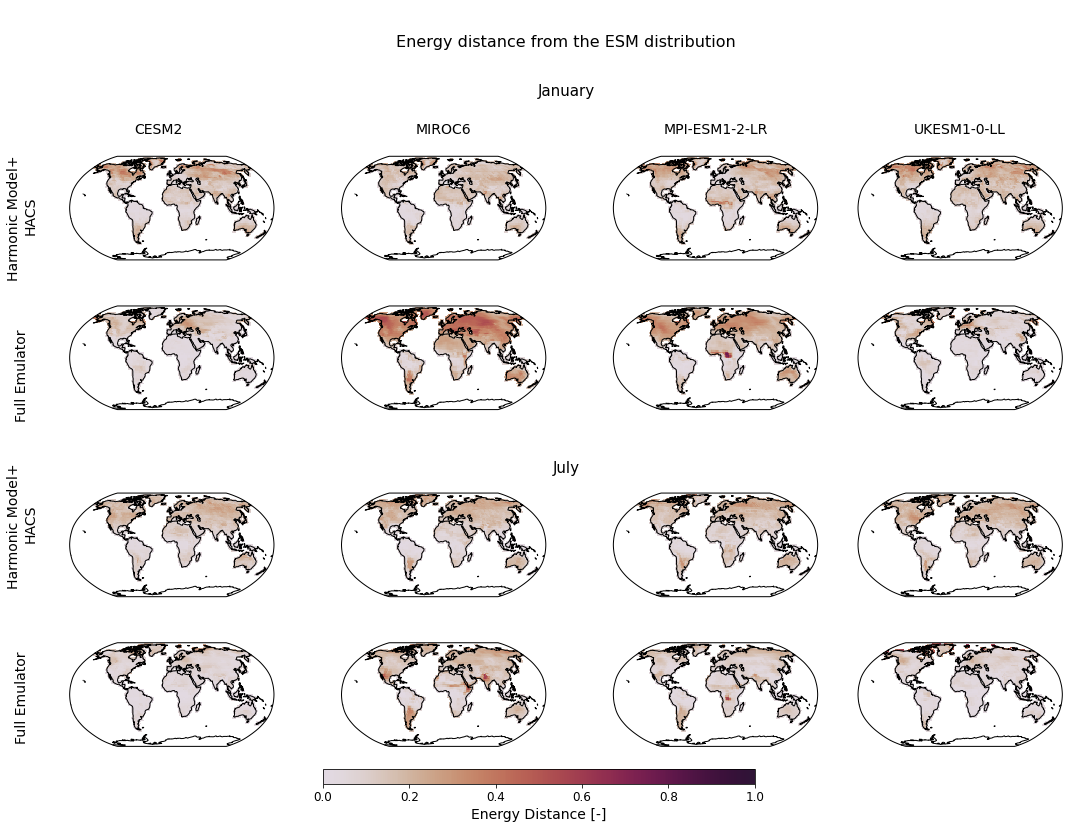

In [8]:
import matplotlib as mpl
import mplotutils as mpu
##Plotting stuff
dir_data = '/net/so4/landclim/snath/data/cmip6-ng/train_test_split_final/'
frac_l = xr.open_mfdataset('/net/so4/landclim/snath/data/interim_invariant_lsmask_regrid.nc', combine='by_coords',decode_times=False)
#land-sea mask of ERA-interim bilinearily interpolated 
frac_l_raw = np.squeeze(copy.deepcopy(frac_l.lsm.values))
frac_l = frac_l.where(frac_l.lat>-60,0) # remove Antarctica from frac_l field (ie set frac l to 0)
idx_l=np.squeeze(frac_l.lsm.values)>0.0 # idex land #-> everything >0 I consider land

lon_pc, lat_pc = mpu.infer_interval_breaks(frac_l.lon, frac_l.lat)


i_y=0

colors1 = plt.cm.bone(np.linspace(0., 1, 256))
colors2 = plt.cm.gist_heat_r(np.linspace(0, 1, 256))
pink = np.array([248/256, 24/256, 148/256, 1])


colors1=colors1[56:]
colors2=colors2[:200]

colors = np.vstack((colors1, colors2))
colors = mpl.colors.LinearSegmentedColormap.from_list('my_colormap', colors)

kldiv=joblib.load(dir_data+'kldiv_emergency_dump_all_mod.pkl')

n_col = 4
n_row = 4

fs_title=16

models=['CESM2','MIROC6','MPI-ESM1-2-LR','UKESM1-0-LL']

fig=plt.figure(figsize=(n_col*4+3, n_row * 6+2))
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'mathtext.default':'regular'}) 
plt.rcParams.update({'mathtext.default':'it'}) 
labels_full=['Harmonic Model+ \nHACS','Full Emulator']

grid = plt.GridSpec(n_row*9+2, n_col*9+3, wspace=0, hspace=0.3) # create a grid for the subplots #0.12

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
axtitle = plt.subplot(grid[0,2:])
plt.title('Energy distance from the ESM distribution',y=-0.6,fontsize=16)
plt.axis('off')

axtitle = plt.subplot(grid[2,:11])
plt.title('CESM2',y=-1,fontsize=14)
plt.axis('off')

axtitle = plt.subplot(grid[2,11:21])
plt.title('MIROC6',y=-1,fontsize=14)
plt.axis('off')

axtitle = plt.subplot(grid[1,2:])
plt.title('January',y=-1,fontsize=15)
plt.axis('off')

axtitle = plt.subplot(grid[2,21:31])
plt.title('MPI-ESM1-2-LR',y=-1,fontsize=14)
plt.axis('off')

axtitle = plt.subplot(grid[2,31:40])
plt.title('UKESM1-0-LL',y=-1,fontsize=14)
plt.axis('off')

axtitle = plt.subplot(grid[12,2:])
plt.title('July',y=0.2,fontsize=15)
plt.axis('off')

axtitle = plt.subplot(grid[6,0])
plt.title(labels_full[0],y=-0.8,fontsize=14, rotation=90)
plt.axis('off')

axtitle = plt.subplot(grid[11,0])
plt.title(labels_full[1],y=0.8,fontsize=14, rotation=90)
plt.axis('off')

axtitle = plt.subplot(grid[14,0])
plt.title(labels_full[0],y=-1.1,fontsize=14, rotation=90)
plt.axis('off')

axtitle = plt.subplot(grid[19,0])
plt.title(labels_full[1],y=0,fontsize=14, rotation=90)
plt.axis('off')
i=3

colors = plt.cm.twilight_shifted(np.linspace(0., 1, 256))

colors=colors[126:]

colors = mpl.colors.LinearSegmentedColormap.from_list('my_colormap', colors)
for res_mod in range(4):        
    labels=['Org','Tyr_mon','HACS']
    
    if res_mod==2:
        #print(i)
        i+=1
        
    if res_mod<2:
        i_mon=0
    else:
        i_mon=1
    
    i_y=0  
    for model in ['CESM2','MIROC6','MPI-ESM1-2-LR','UKESM1-0-LL']:   
    
        ax = plt.subplot(grid[i+1:i+4,i_y*10+1:i_y*10+11], projection=ccrs.Robinson(central_longitude=0))

        y_ma = np.zeros(idx_l.shape)
        y_ma = ma.masked_array(y_ma, mask=idx_l==False)
        

        y_ma[idx_l]=kldiv[model][res_mod%2+1,i_mon,:]#pearsonr_alb[model][res_mod]
        ax.coastlines()
        mesh_1=ax.pcolormesh(lon_pc, lat_pc, y_ma,  cmap=colors,vmin=0,vmax=1, transform=ccrs.PlateCarree(),rasterized=True)
        
        #if res_mod=='Org':
        #    ax.text(0,0,model,rotation=90)
        i_y+=1
    i+=4
        


axcbar = plt.subplot(grid[20,:])
cbar=plt.colorbar(mesh_1,orientation='horizontal', fraction=0.5,aspect=30)
cbar.set_label(r'Energy Distance [-]',fontsize=14)  
plt.axis('off')

plt.savefig('/net/so4/landclim/snath/cvm_dist_sel_esm.pdf', dpi=300)


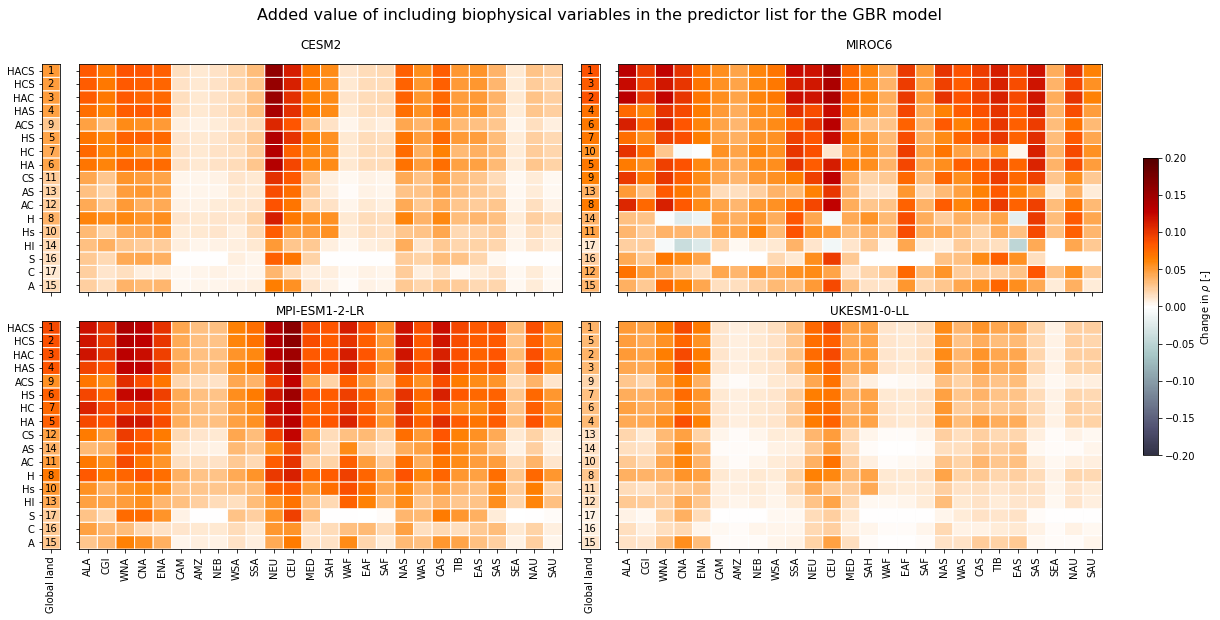

In [90]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

#models = ['CESM1-CAM5','MPI-ESM-LR','MPI-ESM-MR','EC-EARTH']
colors1 = plt.cm.bone(np.linspace(0., 1, 256))
colors2 = plt.cm.gist_heat_r(np.linspace(0, 1, 256))
pink = np.array([248/256, 24/256, 148/256, 1])

#yellow = np.array([255/256, 240/256, 1/256, 1])
#green = np.array([1/256, 255/256, 190/256, 1])
colors1=colors1[56:]
colors2=colors2[:200]

#colors1[-1:, :] = pink
#colors2[:1, :] = pink

#colors1[-4:-1, :] = yellow
#colors2[1:3, :] = green

colors = np.vstack((colors1, colors2))
mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)


srex_raw = xr.open_mfdataset('/net/so4/landclim/snath/data/srex-region-masks_20120709.srex_mask_SREX_masks_all.25deg.time-invariant.nc', combine='by_coords',decode_times=False)
xlabel=['ALA', 'CGI', 'WNA', 'CNA', 'ENA', 'CAM', 'AMZ', 'NEB','WSA', 'SSA', 'NEU', 'CEU', 'MED', 'SAH', 'WAF', 'EAF', 'SAF', 'NAS', 'WAS', 'CAS', 'TIB', 'EAS', 'SAS', 'SEA', 'NAU', 'SAU']

# summary plot
fs_title=16

labels=['A','C','S','Hl','Hs','H','AC','AS','CS','HA','HC','HS','ACS','HAS','HAC','HCS','HACS']
n_row = len(labels)*2

plt.figure(figsize=(20, len(labels)*0.7))

plt.rcParams.update({'font.size': 10})
plt.rcParams.update({'mathtext.default':'it'}) 


grid = plt.GridSpec(n_row*2, 60, wspace=0, hspace=0) # create a grid for the subplots #0.12 

#colors = ["gray","seashell","greenyellow","yellowgreen","lightsalmon","orangered","firebrick"]
#newcmp = LinearSegmentedColormap.from_list("mycmap", colors)

i=6
for i_mod, model in enumerate(['CESM2','MIROC6','MPI-ESM1-2-LR','UKESM1-0-LL']):
    
    if i_mod%2==0:
        i_y = 0
    else:
        i_y=29
        
    
    x,y = np.meshgrid(np.arange(2),np.arange(0,len(labels)+1))
    pearson_mesh_plot = np.zeros([len(labels),1])
    
    for i_res,res_mod in enumerate(labels):
        
        try:
            pearson_mesh_plot[i_res,:] = np.average(
                (pearsonr_alb[model][res_mod]-pearsonr_alb[model]['Tyr_mon']),
            weights=wgt_l)
            #print(model)
        except:
            pearson_mesh_plot[i_res,:]=np.nan
            pass
            
    ranks=np.argsort(pearson_mesh_plot[:,0]).argsort().reshape(-1,1)
    
    #print(model, pearson_mesh_plot)   
    ax1=plt.subplot(grid[i:i+24,i_y])
    mesh = ax1.pcolor(x, y, pearson_mesh_plot, cmap=mymap,edgecolors='w',linewidth=1,vmin=-0.2,vmax=0.2)
    for i_y in range(pearson_mesh_plot.shape[0]):
        for i_x in range(pearson_mesh_plot.shape[1]):
            
            if model=='EC-EARTH':
                if ranks[i_y, i_x]>8:
                    continue
            if model=='EC-EARTH':
                plt.text(i_x + 0.5, i_y + 0.5, '%i' % ((8-ranks[i_y, i_x])+1),
                         horizontalalignment='center',
                         verticalalignment='center',
                         )
            else:
                plt.text(i_x + 0.5, i_y + 0.5, '%i' % ((16-ranks[i_y, i_x])+1),
                         horizontalalignment='center',
                         verticalalignment='center',
                         )

    
    ax1.set_xticks([0.5])
    ax1.set_xticklabels([])
    
    if model=='UKESM1-0-LL' or model=='MPI-ESM1-2-LR':
        ax1.set_xticklabels(['Global land'],rotation=90)
    
    ax1.set_yticks(np.arange(len(labels))+0.5)
    ax1.set_yticklabels([])
    if model=='MPI-ESM1-2-LR' or model=='CESM2':
        ax1.set_yticklabels(np.array(labels).astype(str))  
    
    if i_mod%2==0:
        i_y = 2
    else:
        i_y=31
    
    x,y = np.meshgrid(np.arange(0,len(xlabel)+1),np.arange(0,len(labels)+1))
    pearson_mesh_plot = np.zeros([len(labels),len(xlabel)])
    for i_reg,reg in enumerate(xlabel,1):
        for i_res,res_mod in enumerate(labels):
            
            try:
                pearson_mesh_plot[i_res,i_reg-1] = np.average(
                (pearsonr_alb[model][res_mod][(srex_raw.srex_mask.values[idx_l]==i_reg)]
                      -pearsonr_alb[model]['Tyr_mon'][(srex_raw.srex_mask.values[idx_l]==i_reg)]),
            weights=wgt_l[(srex_raw.srex_mask.values[idx_l]==i_reg)])
            except:
                #print(reg,model,pearsonr_alb[model]['Tyr_mon'],res_mod)
                pearson_mesh_plot[i_res,i_reg-1]=np.nan
                pass
               
    #print(model, pearson_mesh_plot)         
    ax2=plt.subplot(grid[i:i+24,i_y:i_y+26])
    mesh = ax2.pcolor(x, y, pearson_mesh_plot, cmap=mymap,edgecolors='w',linewidth=1,vmin=-0.2,vmax=0.2)
    
    ax2.set_yticks(np.arange(len(labels))+0.5)
    ax2.set_yticklabels([])
    
    ax2.set_xticks(np.arange(26)+0.5)
    ax2.set_xticklabels([])
    if model=='UKESM1-0-LL' or model=='MPI-ESM1-2-LR':
        ax2.set_xticklabels(xlabel,rotation=90)
    
    if i_mod%2!=0:
        i+=27

ax1.set_facecolor('gray')
ax2.set_facecolor('gray')

axtitle = plt.subplot(grid[0,:])
plt.title('Added value of including biophysical variables in the predictor list for the GBR model',y=-1,fontsize=16)
plt.axis('off')

#axtitle = plt.subplot(grid[62,1:-6])
#plt.title('SREX Regions',y=-2.2,fontsize=11)
#plt.axis('off')

axcbar = plt.subplot(grid[1:62,-1:])
cbar=plt.colorbar(mesh, orientation='vertical', fraction=0.8)
cbar.set_label(r"Change in $\rho$ [-]")
plt.axis('off')

axtitle = plt.subplot(grid[1,:30])
plt.title('CESM2',y=-3,fontsize=12)
plt.axis('off')

axtitle = plt.subplot(grid[1,30:-1])
plt.title('MIROC6',y=-3,fontsize=12)
plt.axis('off')

axtitle = plt.subplot(grid[30,:30])
plt.title('MPI-ESM1-2-LR',y=-2,fontsize=12)
plt.axis('off')

axtitle = plt.subplot(grid[30,30:-1])
plt.title('UKESM1-0-LL',y=-2,fontsize=12)
plt.axis('off')
plt.savefig('/net/so4/landclim/snath/gbr_icomp_sel_mod.pdf', dpi=300)



(0.0, 1.0, 0.0, 1.0)

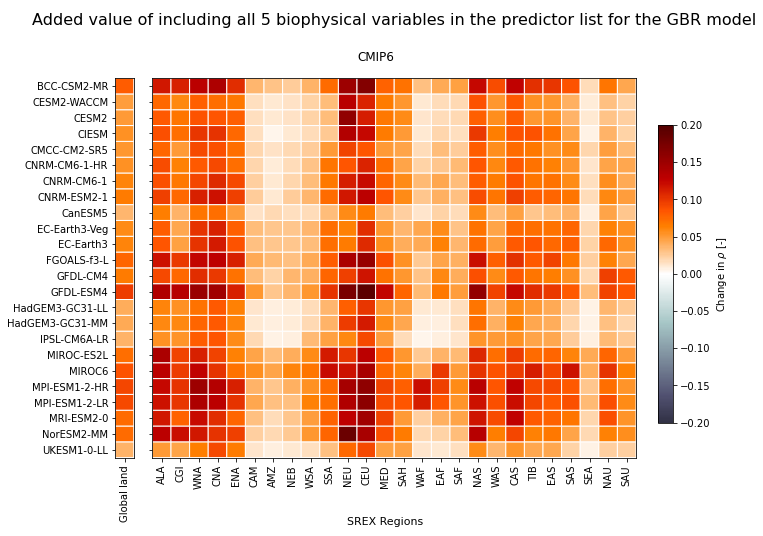

In [8]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

models=[]
for model in pearsonr_alb.keys():
    if 'HACS' in pearsonr_alb[model].keys():
        models.append(model)
colors1 = plt.cm.bone(np.linspace(0., 1, 256))
colors2 = plt.cm.gist_heat_r(np.linspace(0, 1, 256))
colors1=colors1[56:]
colors2=colors2[:200]
colors = np.vstack((colors1, colors2))
mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)


srex_raw = xr.open_mfdataset('/net/so4/landclim/snath/data/srex-region-masks_20120709.srex_mask_SREX_masks_all.25deg.time-invariant.nc', combine='by_coords',decode_times=False)
xlabel=['ALA', 'CGI', 'WNA', 'CNA', 'ENA', 'CAM', 'AMZ', 'NEB','WSA', 'SSA', 'NEU', 'CEU', 'MED', 'SAH', 'WAF', 'EAF', 'SAF', 'NAS', 'WAS', 'CAS', 'TIB', 'EAS', 'SAS', 'SEA', 'NAU', 'SAU']

# summary plot
fs_title=16

labels=models
n_row = len(labels)*2

plt.figure(figsize=(10, (len(labels))*0.5))

plt.rcParams.update({'font.size': 10})
plt.rcParams.update({'mathtext.default':'it'}) 


grid = plt.GridSpec(55, 30, wspace=0, hspace=0) # create a grid for the subplots #0.12 


'''CMIP6'''

i=6

    
i_y = 0

x,y = np.meshgrid(np.arange(2),np.arange(0,len(labels)+1))
pearson_mesh_plot = np.zeros([len(labels),1])

for i_res,model in enumerate(labels[::-1]):

    try:
        pearson_mesh_plot[i_res,:] = np.average(
            (pearsonr_alb[model]['HACS']-pearsonr_alb[model]['Tyr_mon']),
        weights=wgt_l)

    except:
        pearson_mesh_plot[i_res,:]=np.nan
        pass
ax1=plt.subplot(grid[i:i+32,i_y])
mesh = ax1.pcolor(x, y, pearson_mesh_plot, cmap=mymap,edgecolors='w',linewidth=1,vmin=-0.2,vmax=0.2)

ax1.set_xticks([0.5])
ax1.set_xticklabels(['Global land'],rotation=90)

ax1.set_yticks(np.arange(len(labels))+0.5)
ax1.set_yticklabels(np.array(labels[::-1]).astype(str))

i_y=2

x,y = np.meshgrid(np.arange(0,len(xlabel)+1),np.arange(0,len(labels)+1))
pearson_mesh_plot = np.zeros([len(labels),len(xlabel)])

for i_reg,reg in enumerate(xlabel,1):
    for i_res,model in enumerate(labels[::-1]):

        try:
            pearson_mesh_plot[i_res,i_reg-1] = np.average(
            (pearsonr_alb[model]['HACS'][(srex_raw.srex_mask.values[idx_l]==i_reg)]
                  -pearsonr_alb[model]['Tyr_mon'][(srex_raw.srex_mask.values[idx_l]==i_reg)]),
        weights=wgt_l[(srex_raw.srex_mask.values[idx_l]==i_reg)])
        except:
            pearson_mesh_plot[i_res,i_reg-1]=np.nan
            pass

ax2=plt.subplot(grid[i:i+32,i_y:i_y+26])
mesh = ax2.pcolor(x, y, pearson_mesh_plot, cmap=mymap,edgecolors='w',linewidth=1,vmin=-0.2,vmax=0.2)

ax2.set_yticks(np.arange(len(labels))+0.5)
ax2.set_yticklabels([])

ax2.set_xticks(np.arange(26)+0.5)
ax2.set_xticklabels(xlabel,rotation=90)


axtitle = plt.subplot(grid[0,:])
plt.title('Added value of including all 5 biophysical variables in the predictor list for the GBR model',y=-1,fontsize=16)
plt.axis('off')
axtitle = plt.subplot(grid[1,:-2])
plt.title('CMIP6',y=-3,fontsize=12)
plt.axis('off')

axtitle = plt.subplot(grid[43,1:-2])
plt.title('SREX Regions',y=-0.2,fontsize=11)
plt.axis('off')

axcbar = plt.subplot(grid[5:40,-1:])
cbar=plt.colorbar(mesh, orientation='vertical', fraction=0.8)
cbar.set_label(r"Change in $\rho$ [-]")
plt.axis('off')



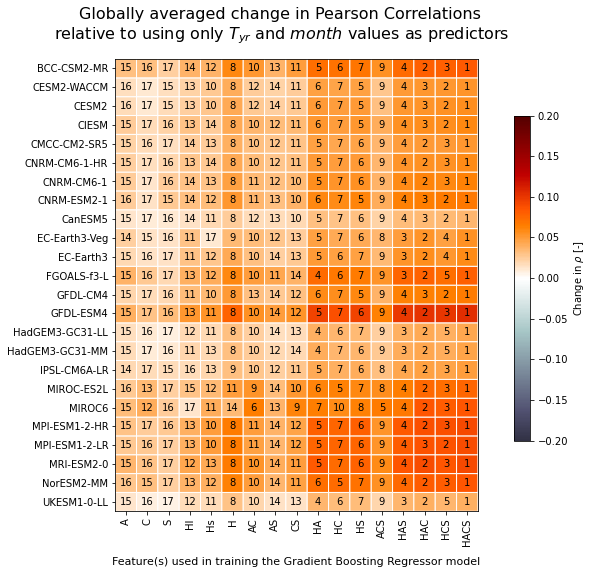

In [18]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

pearsonr_alb=joblib.load(dir_data+'GBR_pearson_coeffs_icomp_all_esms.pkl')

models=[]
for model in pearsonr_alb.keys():
    if 'HACS' in pearsonr_alb[model].keys():
        models.append(model)
colors1 = plt.cm.bone(np.linspace(0., 1, 256))
colors2 = plt.cm.gist_heat_r(np.linspace(0, 1, 256))
colors1=colors1[56:]
colors2=colors2[:200]
colors = np.vstack((colors1, colors2))
mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)


xlabel=['A','C','S','Hl','Hs','H','AC','AS','CS','HA','HC','HS','ACS','HAS','HAC','HCS','HACS']

# summary plot
fs_title=16

labels=models
n_row = len(labels)*2

plt.figure(figsize=(10, len(labels)*0.6-4))

plt.rcParams.update({'font.size': 10})
plt.rcParams.update({'mathtext.default':'it'}) 


grid = plt.GridSpec(40, 40, wspace=0, hspace=0) # create a grid for the subplots #0.12 

'''CMIP6'''

i=3

    

i_y=9

x,y = np.meshgrid(np.arange(0,len(xlabel)+1),np.arange(0,len(labels)+1))
pearson_mesh_plot = np.zeros([len(labels),len(xlabel)])

for i_reg,reg in enumerate(xlabel,1):
    for i_res,model in enumerate(labels[::-1]):
        
        try:
            pearson_mesh_plot[i_res,i_reg-1] = np.average(
            (pearsonr_alb[model][reg]
                  -pearsonr_alb[model]['Tyr_mon']))
        except:
            pearson_mesh_plot[i_res,i_reg-1]=np.nan
            pass
        
        
        
ax2=plt.subplot(grid[i:i+32,i_y:i_y+26])
mesh = ax2.pcolor(x, y, pearson_mesh_plot, cmap=mymap,edgecolors='w',linewidth=1,vmin=-0.2,vmax=0.2)
ranks=np.argsort(np.argsort(pearson_mesh_plot,axis=1),axis=1)
for i_y in range(pearson_mesh_plot.shape[0]):
    for i_x in range(pearson_mesh_plot.shape[1]):
            plt.text(i_x + 0.5, i_y + 0.5, '%i' % ((16-ranks[i_y, i_x])+1),
                     horizontalalignment='center',
                     verticalalignment='center',
                     )
ax2.set_yticks(np.arange(len(labels))+0.5)
ax2.set_yticklabels(labels[::-1])

ax2.set_xticks(np.arange(17)+0.5)
ax2.set_xticklabels(xlabel,rotation=90)


axtitle = plt.subplot(grid[0,8:])
plt.title('Globally averaged change in Pearson Correlations\n relative to using only $T_{yr}$ and $month$ values as predictors ',y=-1,x=0.4,fontsize=16)
plt.axis('off')


axtitle = plt.subplot(grid[38,8:-4])
plt.title('Feature(s) used in training the Gradient Boosting Regressor model',y=-0.2,fontsize=11)
plt.axis('off')

axcbar = plt.subplot(grid[7:30,-3:])
cbar=plt.colorbar(mesh, orientation='vertical', fraction=0.8)
cbar.set_label(r"Change in $\rho$ [-]")
plt.axis('off')
plt.savefig('/net/so4/landclim/snath/gbr_icomp_all_mod.pdf', dpi=300)

In [202]:
ranks

array([[11,  8, 12, 16, 13,  4,  0,  1,  6,  7, 14, 15, 10,  9,  3,  2,
         5],
       [ 0, 14, 13, 12, 11, 10,  9, 15,  8,  6,  5,  4,  3,  2,  1,  7,
        16],
       [ 0, 14, 13, 12, 11, 10,  9, 15,  8,  6,  5,  4,  3,  2,  1,  7,
        16],
       [ 0, 14, 13, 12, 11, 10,  9, 15,  8,  6,  5,  4,  3,  2,  1,  7,
        16],
       [ 0, 14, 13, 12, 11, 10,  9, 15,  8,  6,  5,  4,  3,  2,  1,  7,
        16],
       [ 0, 14, 13, 12, 11, 10,  9, 15,  8,  6,  5,  4,  3,  2,  1,  7,
        16],
       [ 0, 14, 13, 12, 11, 10,  9, 15,  8,  6,  5,  4,  3,  2,  1,  7,
        16],
       [ 0, 14, 13, 12, 11, 10,  9, 15,  8,  6,  5,  4,  3,  2,  1,  7,
        16],
       [ 0, 14, 13, 12, 11, 10,  9, 15,  8,  6,  5,  4,  3,  2,  1,  7,
        16],
       [ 0, 14, 13, 12, 11, 10,  9, 15,  8,  6,  5,  4,  3,  2,  1,  7,
        16],
       [ 0, 14, 13, 12, 11, 10,  9, 15,  8,  6,  5,  4,  3,  2,  1,  7,
        16],
       [ 0, 14, 13, 12, 11, 10,  9, 15,  8,  6,  5,  4,  3,  2,  

In [207]:
 pearson_mesh_plot[i_res,i_reg-1] = np.average(
            (pearsonr_alb[model][reg]
                  -pearsonr_alb[model]['Tyr_mon']))

In [209]:
pearsonr_alb[model]

{'HACS': array([0.97514981, 0.9731324 , 0.97556273, ..., 0.97406872, 0.97553149,
        0.97902859]),
 'Tyr_mon': array([0.90776725, 0.90231062, 0.89437786, ..., 0.9680364 , 0.96955482,
        0.97183541])}

In [211]:
models

['CESM1-CAM5',
 'MPI-ESM-LR',
 'MPI-ESM-MR',
 'BCC-CSM2-MR',
 'CESM2-WACCM',
 'CESM2',
 'CIESM',
 'CMCC-CM2-SR5',
 'CNRM-CM6-1-HR',
 'CNRM-CM6-1',
 'CNRM-ESM2-1',
 'CanESM5',
 'EC-Earth3-Veg',
 'EC-Earth3',
 'FGOALS-f3-L',
 'GFDL-CM4',
 'GFDL-ESM4',
 'HadGEM3-GC31-LL',
 'HadGEM3-GC31-MM',
 'MIROC-ES2L',
 'MIROC6',
 'MPI-ESM1-2-HR',
 'MPI-ESM1-2-LR',
 'MRI-ESM2-0',
 'UKESM1-0-LL']

In [222]:
pearsonr_alb['BCC-CSM2-MR'].keys()

dict_keys(['Org'])

In [237]:
list(pearsonr_alb.keys())

['CESM1-CAM5',
 'MPI-ESM-LR',
 'MPI-ESM-MR',
 'EC-EARTH',
 'ACCESS-CM2',
 'ACCESS-ESM1-5',
 'AWI-CM-1-1-MR',
 'BCC-CSM2-MR',
 'CAMS-CSM1-0',
 'CESM2-WACCM',
 'CESM2',
 'CIESM',
 'CMCC-CM2-SR5',
 'CNRM-CM6-1-HR',
 'CNRM-CM6-1',
 'CNRM-ESM2-1',
 'CanESM5',
 'EC-Earth3-Veg',
 'EC-Earth3',
 'FGOALS-f3-L',
 'FGOALS-g3',
 'FIO-ESM-2-0',
 'GFDL-CM4',
 'GFDL-ESM4',
 'HadGEM3-GC31-LL',
 'HadGEM3-GC31-MM',
 'INM-CM4-8',
 'INM-CM5-0',
 'KACE-1-0-G',
 'KIOST-ESM',
 'MCM-UA-1-0',
 'MIROC-ES2L',
 'MIROC6']

In [246]:
pearsonr_alb[model]

{'A': array([0.8369211 , 0.82820801, 0.82181626, ..., 0.91936337, 0.91971471,
        0.91810111]),
 'C': array([0.85820256, 0.85020078, 0.83810851, ..., 0.93054745, 0.93132896,
        0.93272205]),
 'S': array([0.82923195, 0.82266214, 0.81703551, ..., 0.92360178, 0.92385879,
        0.92278536]),
 'Hl': array([0.89704606, 0.89698404, 0.9066677 , ..., 0.92300798, 0.92450226,
        0.92350732]),
 'Hs': array([0.93653896, 0.93856223, 0.94451865, ..., 0.92378189, 0.92400882,
        0.92363612]),
 'H': array([0.94184009, 0.94346453, 0.94896282, ..., 0.93513114, 0.93540702,
        0.93576714]),
 'AC': array([0.86135527, 0.85325092, 0.84338387, ..., 0.9393934 , 0.93854592,
        0.9400121 ]),
 'AS': array([0.84741039, 0.83953336, 0.83520477, ..., 0.92830344, 0.92821022,
        0.9286154 ]),
 'CS': array([0.86698896, 0.85782936, 0.8482501 , ..., 0.94249187, 0.94366905,
        0.94355052]),
 'HA': array([0.94509663, 0.94748377, 0.95158935, ..., 0.93859997, 0.93855622,
        0.938636

In [254]:
lat_pc

array([-90. , -87.5, -85. , -82.5, -80. , -77.5, -75. , -72.5, -70. ,
       -67.5, -65. , -62.5, -60. , -57.5, -55. , -52.5, -50. , -47.5,
       -45. , -42.5, -40. , -37.5, -35. , -32.5, -30. , -27.5, -25. ,
       -22.5, -20. , -17.5, -15. , -12.5, -10. ,  -7.5,  -5. ,  -2.5,
         0. ,   2.5,   5. ,   7.5,  10. ,  12.5,  15. ,  17.5,  20. ,
        22.5,  25. ,  27.5,  30. ,  32.5,  35. ,  37.5,  40. ,  42.5,
        45. ,  47.5,  50. ,  52.5,  55. ,  57.5,  60. ,  62.5,  65. ,
        67.5,  70. ,  72.5,  75. ,  77.5,  80. ,  82.5,  85. ,  87.5,
        90. ], dtype=float32)